This is where we analyze the pkls of already-run experiments. The plots for the paper were generated in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [33]:
instances = ['Eugene_2020', 'Petaluma_2022', 'Deschutes_2024']
dataset = "HD"

# instance_names = ["ABY", "ABZ", "ACA", "ACB"]

PLOT_INSTANCE_NAME = {'Eugene_2020': 'US-1', 'Petaluma_2022': 'US-2', 'Deschutes_2024': 'US-3', 'ABY': 'Can-1', 'ABZ': 'Can-2', 'ACA': 'Can-3', 'ACB': 'Can-4'}
PLOT_DATASET_NAME = {'HD': 'US', 'MASS_ALDFN': 'Can'}


In [91]:

ALG_NAMES = {'L1 Opt': r'$\mathsf{ERM-ALTS}^1$', 'Binary Opt': r'$\mathsf{ERM-ALTS}^{0/1}$', 
             'Practitioner': r'$\mathsf{QUOTA-BASED}$', 'Greedy': r'$\mathsf{GREEDY}$', 
             'L1 Eq Probs': r'$\mathsf{ERM-ALTS}^1\mathsf{-EQ}$'}

default_plot_args = {'with_stddev': True, 'ylabel': r"$L^{\ell_1}$ Loss", 'ylim' : (-0.1, 3.1), 'include_titles' : True, 'include_legend' : True, 'include_xlabels': True}
def plot_losses_for_dataset(instance_names, all_alt_indices, upper_bound, lower_bound, losses, loss_labels, ks, filename, true_prac_losses = None, plot_args = default_plot_args):
    num_instances = len(instance_names)
    fig, axes = plt.subplots(1, num_instances, figsize=(20, 6), sharey=True, constrained_layout=True)
    leg_index = len(instance_names) - 1
    for i, instance_name in enumerate(instance_names):
        alt_indices = all_alt_indices[instance_name]
        inst_loss = losses[instance_name]
        ax = axes[i]
        if 'L1 Opt' in loss_labels:
            colors = {
                'L1 Opt': '#A020F0', # purple
                'Binary Opt': '#FFA500',         # Bright orange
                'Practitioner': '#0077BB',         # Green
                'Greedy': '#d62728',   # Dark red 
                'L1 Eq Probs': '#17becf',     # Teal/Cyan
                'Real Prac Set': '#009988'
            }
        else:
            colors = {label: plt.get_cmap('tab10')(i) for i, label in enumerate(loss_labels)}

        # storing legend info
        lines = []
        labels = []
        
        if plot_args['with_stddev']:
            for label in loss_labels:
                means, stds = inst_loss[label]
                ax.fill_between(
                    alt_indices,
                    np.array(means),
                    np.array(means) + np.array(stds),
                    alpha=0.1,
                    color=colors[label],
                )
                
            for label in loss_labels:
                means, stds = inst_loss[label]
                ax.plot(
                    alt_indices,
                    np.array(means) + np.array(stds),
                    color=colors[label],
                    linestyle='--',
                    linewidth=1.25,
                    alpha=0.5 # Less transparent than the fill
                )
        
        # Second loop to plot the means
        for label in loss_labels:
            means, stds = inst_loss[label]
            line = ax.plot(alt_indices, means, label=label, color=colors[label], linewidth=1.75)
            if i == leg_index:
                lines.extend(line)
                labels.append(ALG_NAMES[label])

        if true_prac_losses[instance_name] is not None:
            true_prac_loss = true_prac_losses[instance_name]
            scatter = ax.scatter(true_prac_loss[0], true_prac_loss[1], color=colors['Real Prac Set'], label='Practitioner Alternate Set')
            if i == leg_index:
                lines.append(scatter)
                labels.append('Practitioner Alternates')

        left_shift = 1.7
        if "MASS" in filename:
            left_shift = 2.7
        if upper_bound[instance_name] is not None:
            ax.axhline(y=float(upper_bound[instance_name]), color='k', linestyle='-', linewidth=2, label='_nolegend_')
            ax.text(alt_indices[-1]-left_shift, float(upper_bound[instance_name])+0.03, r'$A = \varnothing$', color='k', fontsize=14, verticalalignment='bottom')
        if lower_bound[instance_name] is not None:
            ax.axhline(y=float(lower_bound[instance_name]), color='k', linestyle='-', linewidth=2, label='_nolegend_')
            ax.text(alt_indices[-1] - left_shift, float(lower_bound[instance_name]) - 0.15, r'$A = N$', color='k', fontsize=14, verticalalignment='bottom')

        if plot_args['include_titles']:
            ax.set_title(f"{PLOT_INSTANCE_NAME[instance_name]}, $k={ks[instance_name]}$", fontsize=19)

        labeled_alt_indices = [ind for ind in alt_indices if ind < 2 or ind > 3]
        xticks = [f"$\\frac{{k}}{{{int(ks[instance_name])//int(x)}}}$" if int(x) != int(ks[instance_name]) else r"$k$" for x in labeled_alt_indices]
        if "MASS" in filename:
            ax.set_xticks(alt_indices)
            ax.set_xticklabels(alt_indices, fontsize=17)
        else:
            ax.set_xticks(labeled_alt_indices)
            ax.set_xticklabels(xticks, fontsize=17)
        
        ax.set_ylim(plot_args['ylim'][0], plot_args['ylim'][1])
        ax.tick_params(axis='y', labelsize=14)
        
        if i == leg_index and plot_args['include_legend']: # no stddev
            ax.legend(lines, labels, fontsize=13, loc='upper right', bbox_to_anchor=(1.0, 0.95))
        
    # fig.suptitle(r"$L^1$ Loss Convergence", fontsize=16)
    if plot_args['include_xlabels']:
        fig.supxlabel('Number of Alternates', fontsize=19)
    fig.supylabel(plot_args['ylabel'], fontsize=16)
    # fig.set_constrained_layout(True)
    # fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15)

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [ ]:
# plotting simulated dropout sets
loss_metric = "l1"
pool_drop_string = ""
NUM_BINARY_SAMPLES = 300
NUM_L1_SAMPLES = 300
loss_labels = ['Practitioner', 'Greedy', 'L1 Eq Probs', 'Binary Opt', 'L1 Opt']
dataset = "HD"

file_path = f"../plots/simulation3/{dataset}/pkls/simulation3_output_loss_{loss_metric}{pool_drop_string}_{NUM_BINARY_SAMPLES}_{NUM_L1_SAMPLES}.pkl"
with open(file_path, "rb") as f:
    output_data = pickle.load(f)

all_alt_indices = output_data["all_alt_indices"]
ubs = output_data["ubs"]
lbs = output_data["lbs"]
losses = output_data["losses"]
ks = output_data["ks"]
true_prac_loss_tuples = output_data["true_prac_loss_tuples"]
instance_names = ["Eugene_2020", "Petaluma_2022", "Deschutes_2024"]
y_axis_label = r"$L^{\ell_1}(A, \hat{\mathcal{D}}_{\boldsymbol{\rho}})$"
plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation3/{dataset}/{dataset}_losses_{loss_metric}_line_plot_no_stddev.pdf", true_prac_loss_tuples, with_stddev=False, ylabel=y_axis_label)
# plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation3/{dataset}/{dataset}_losses_{loss_metric}_line_plot_with_stddev.pdf", true_prac_loss_tuples, with_stddev=True, ylabel=y_axis_label)

In [ ]:
# plotting real dropout sets
loss_metric = "l1"
pool_drop_string = ""
NUM_BINARY_SAMPLES = 300
NUM_L1_SAMPLES = 300
loss_labels = ['Practitioner', 'Greedy', 'L1 Eq Probs', 'Binary Opt', 'L1 Opt']
dataset = "HD"

file_path = f"../plots/simulation1/{dataset}/pkls/simulation1_output_loss_{loss_metric}{pool_drop_string}_{NUM_BINARY_SAMPLES}_{NUM_L1_SAMPLES}.pkl"
with open(file_path, "rb") as f:
    output_data = pickle.load(f)

all_alt_indices = output_data["all_alt_indices"]
ubs = output_data["ubs"]
lbs = output_data["lbs"]
losses = output_data["losses"]
ks = output_data["ks"]
true_prac_loss_tuples = output_data["true_prac_loss_tuples"]
instance_names = ["Eugene_2020", "Petaluma_2022", "Deschutes_2024"]
y_axis_label = r'$dev^{\ell_1}(K \setminus D \cup R)$'
plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation1/{dataset}/{dataset}_losses_{loss_metric}_line_plot_no_stddev.pdf", true_prac_loss_tuples, with_stddev=False, ylabel=y_axis_label)
# plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation1/{dataset}/{dataset}_losses_{loss_metric}_line_plot_with_stddev.pdf", true_prac_loss_tuples, with_stddev=True)


{'Practitioner': (1.4123271325624267, None), 'Greedy': (1.5351353276353275, None), 'L1 Eq Probs': (0.7709254231607173, None), 'Binary Opt': (0.6517983073571308, None), 'L1 Opt': (0.5974234120998828, None)}
{'Practitioner': (1.4123271325624267, None), 'Greedy': (1.61873104407575, 0.020332217192322963), 'L1 Eq Probs': (0.7709254231607173, None), 'Binary Opt': (0.6685145433216021, 0.016150480154131983), 'L1 Opt': (0.6336339668174962, 0.007933443891586695)}
{'Practitioner': (1.4123271325624267, None), 'Greedy': (1.684250812803754, 0.028682254399544492), 'L1 Eq Probs': (0.7709254231607173, None), 'Binary Opt': (0.9921786190715601, 0.052061570495225695), 'L1 Opt': (0.7356372314395844, 0.019533560993462755)}
{'Practitioner': (1.4123271325624267, None), 'Greedy': (1.7457626009720129, 0.02300588645389906), 'L1 Eq Probs': (0.7709254231607173, None), 'Binary Opt': (1.162146696832579, 0.05414869981868472), 'L1 Opt': (0.8864045885704709, 0.02650021188946932)}
{'Practitioner': (1.3139651266489503, N

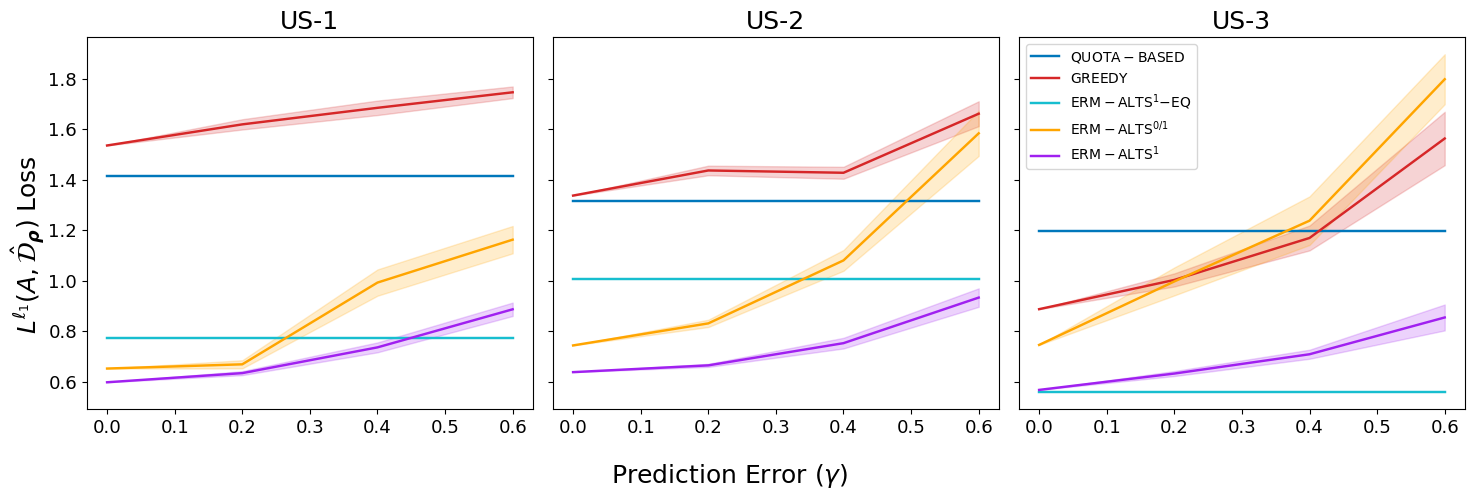

In [ ]:
# robustness plots
gammas = [0, 0.2, 0.4, 0.6]
loss_labels = ['Practitioner', 'Greedy', 'L1 Eq Probs', 'Binary Opt', 'L1 Opt']

instance_names = ["Eugene_2020", "Petaluma_2022", "Deschutes_2024"]
colors = {
                'L1 Opt': '#A020F0', # purple
                'Binary Opt': '#FFA500',         # Bright orange
                'Practitioner': '#0077BB',         # Green
                'Greedy': '#d62728',   # Dark red 
                'L1 Eq Probs': '#17becf',     # Teal/Cyan
                'Real Prac Set': '#009988'
            }
loss_metric = "l1"
pool_drop_string = ""
NUM_BINARY_SAMPLES = 300
NUM_L1_SAMPLES = 300
dataset = "HD"

file_path = f"../plots/simulation3/{dataset}/pkls/simulation3_output_loss_{loss_metric}{pool_drop_string}_{NUM_BINARY_SAMPLES}_{NUM_L1_SAMPLES}.pkl"
with open(file_path, "rb") as f:
    sim3_output_data = pickle.load(f)

index_6 = 4
all_alt_indices = sim3_output_data["all_alt_indices"]
sim_3_losses = sim3_output_data["losses"]
fixed_losses = {instance: {} for instance in instance_names}
for instance in instance_names:
    fixed_losses[instance]['Practitioner'] = sim_3_losses[instance]['Practitioner'][0][index_6]
    fixed_losses[instance]['L1 Eq Probs'] = sim_3_losses[instance]['L1 Eq Probs'][0][index_6]

data = {instance: {} for instance in instance_names}
for instance in instance_names:
    for gamma in gammas:
        file_path = f"../logging/HD/robustness/robustness_test_{instance}_losses_gamma_{gamma}_num_alts_6.pkl"
        with open(file_path, "rb") as f:
            output_data = pickle.load(f)
        # Petaluma had two separate runs that we had to combine
        if instance == "Petaluma_2022":
            file_path_old = f"../logging/HD/robustness/Petaluma_robustness_initial_10/robustness_test_{instance}_losses_gamma_{gamma}_num_alts_6.pkl"
            with open(file_path_old, "rb") as f2:
                output_data_old = pickle.load(f2)
                
        loss_dict = {}
        for label in loss_labels:
            if label in ['Greedy', 'Binary Opt', 'L1 Opt']:
                if instance == "Petaluma_2022":
                    all_errs = output_data[f"{label.split()[0].lower()}_errs"] + output_data_old[f"{label.split()[0].lower()}_errs"]
                else:
                    all_errs = output_data[f"{label.split()[0].lower()}_errs"]
                    
                mean = np.mean(all_errs)
                std_err = None
                if gamma > 0:
                    # all_errs = output_data[f"{label.split()[0].lower()}_errs"]
                    chunked_errs = [all_errs[i:i + NUM_BINARY_SAMPLES] for i in range(0, len(all_errs), NUM_BINARY_SAMPLES)]
                    means = [np.mean(chunk) for chunk in chunked_errs]
                    std_err = np.std(means) / np.sqrt(len(means))
                loss_dict[label] = (mean, std_err)
            else:
                loss_dict[label] = (fixed_losses[instance][label], None)
        print(loss_dict)        
        data[instance][gamma] = loss_dict

fig, axs = plt.subplots(1, len(instance_names), figsize=(5 * len(instance_names), 5), sharey=True)

for i, instance in enumerate(instance_names):
    ax = axs[i]
    for label in loss_labels:
        means = [data[instance][gamma][label][0] for gamma in gammas]
        std_errs = [data[instance][gamma][label][1] for gamma in gammas]
        ax.plot(gammas, means, label=ALG_NAMES[label], color = colors[label], linewidth=1.75)
        if any(std_err is not None for std_err in std_errs):
            lower_bounds = [mean - std_err if std_err is not None else mean for mean, std_err in zip(means, std_errs)]
            upper_bounds = [mean + std_err if std_err is not None else mean for mean, std_err in zip(means, std_errs)]
            ax.fill_between(gammas, lower_bounds, upper_bounds, alpha=0.2, color=colors[label])

    ax.set_title(PLOT_INSTANCE_NAME[instance], fontsize=18)
    if i == 2:
        ax.legend()
    
    ax.tick_params(axis='both', which='major', labelsize=13)
        
fig.supxlabel(r'Prediction Error ($\gamma$)', fontsize=18)
fig.supylabel(r"$L^{\ell_1}(A, \hat{\mathcal{D}}_{\boldsymbol{\rho}})$ Loss", fontsize=18)

plt.tight_layout()
plt.savefig(f"../plots/robustness/HD_new_Petaluma_robustness_gamma_line_plot_with_stderr.pdf", bbox_inches='tight')
plt.show()


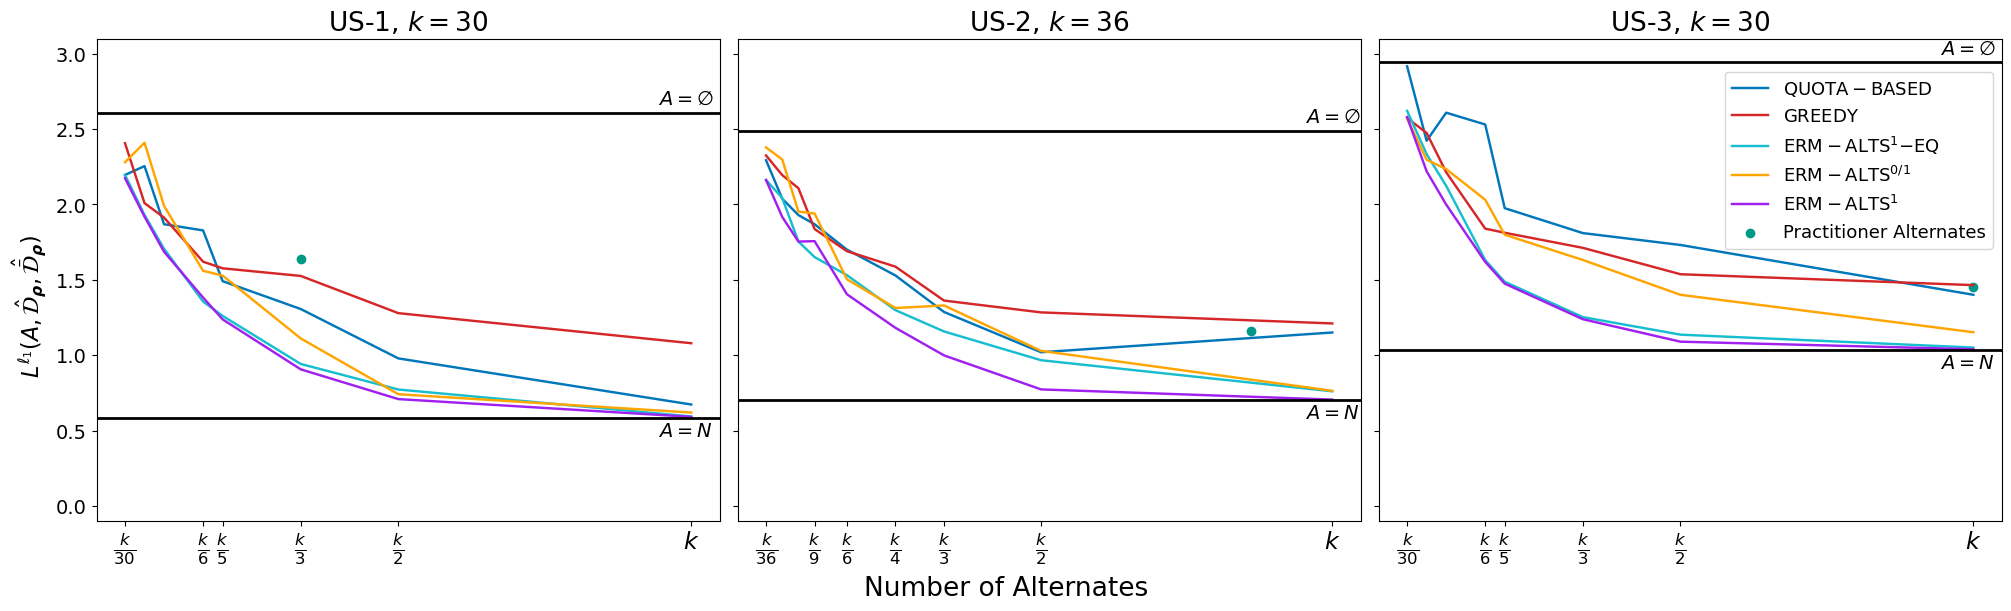

In [92]:
# plotting alternate dropout sets
loss_metric = "l1"
pool_drop_string = '_with_alt_drops'
NUM_BINARY_SAMPLES = 300
NUM_L1_SAMPLES = 300
loss_labels = ['Practitioner', 'Greedy', 'L1 Eq Probs', 'Binary Opt', 'L1 Opt']
dataset = "HD"

file_path = f"../plots/simulation3/{dataset}/pkls/simulation3_output_loss_{loss_metric}{pool_drop_string}_{NUM_BINARY_SAMPLES}_{NUM_L1_SAMPLES}.pkl"
with open(file_path, "rb") as f:
    output_data = pickle.load(f)

all_alt_indices = output_data["all_alt_indices"]
ubs = output_data["ubs"]
lbs = output_data["lbs"]
losses = output_data["losses"]
ks = output_data["ks"]
true_prac_loss_tuples = output_data["true_prac_loss_tuples"]
instance_names = ["Eugene_2020", "Petaluma_2022", "Deschutes_2024"]
y_axis_label = r"$L^{\ell_1}(A, \hat{\mathcal{D}}_{\boldsymbol{\rho}}, \hat{\mathcal{\bar{D}}}_{\boldsymbol{\rho}})$"
alt_plot_args = {'with_stddev': False, 'ylabel': y_axis_label, 'ylim' : (-0.1, 3.1), 'include_titles' : True, 'include_legend' : True, 'include_xlabels': True}

plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation3/{dataset}/{dataset}_losses_{loss_metric}{pool_drop_string}_line_plot_no_stddev.pdf", true_prac_loss_tuples, plot_args=alt_plot_args)
# plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation3/{dataset}/{dataset}_losses_{loss_metric}{pool_drop_string}_line_plot_with_stddev.pdf", true_prac_loss_tuples, with_stddev=True, ylabel=y_axis_label)

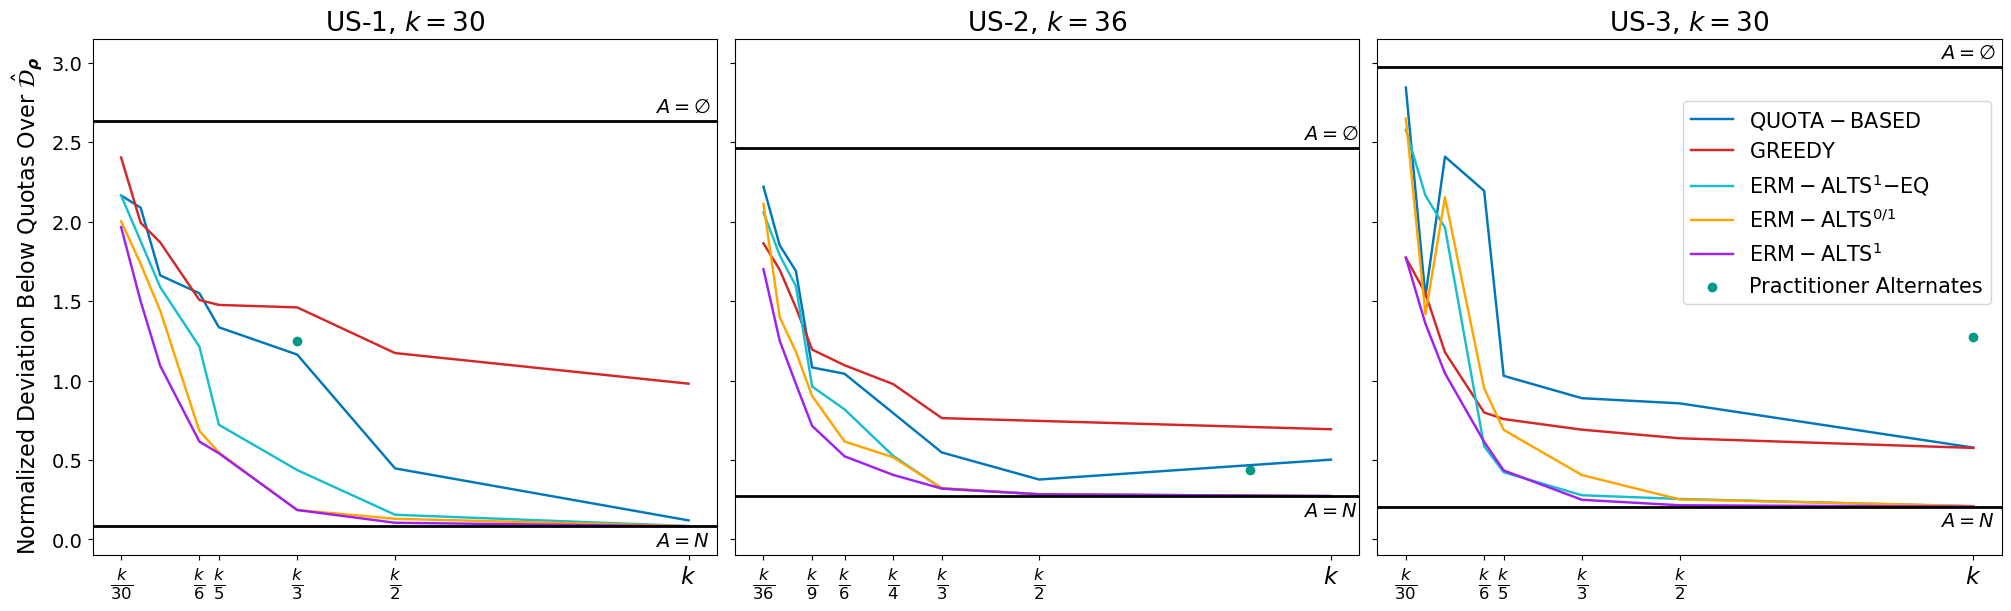

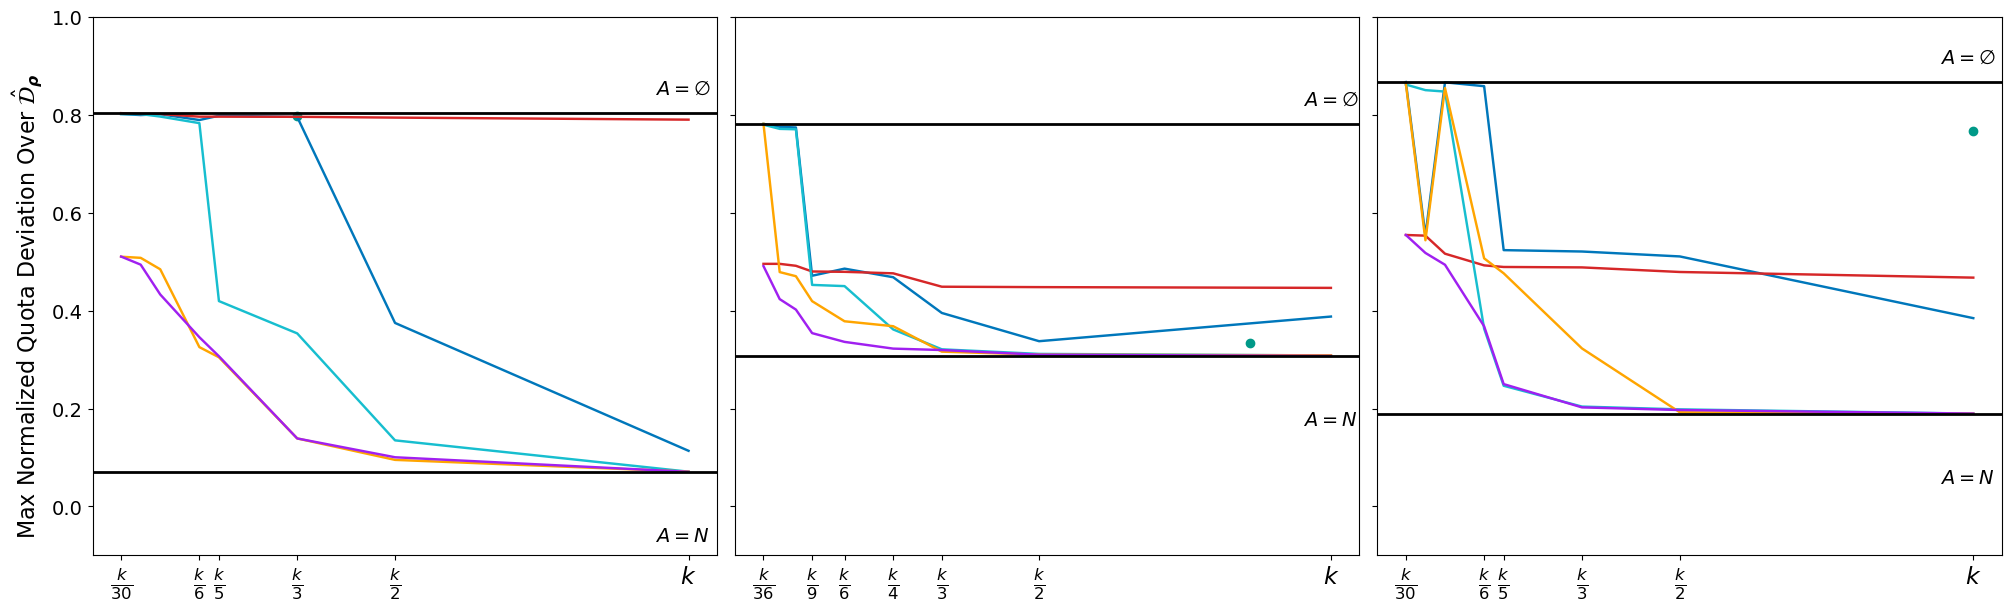

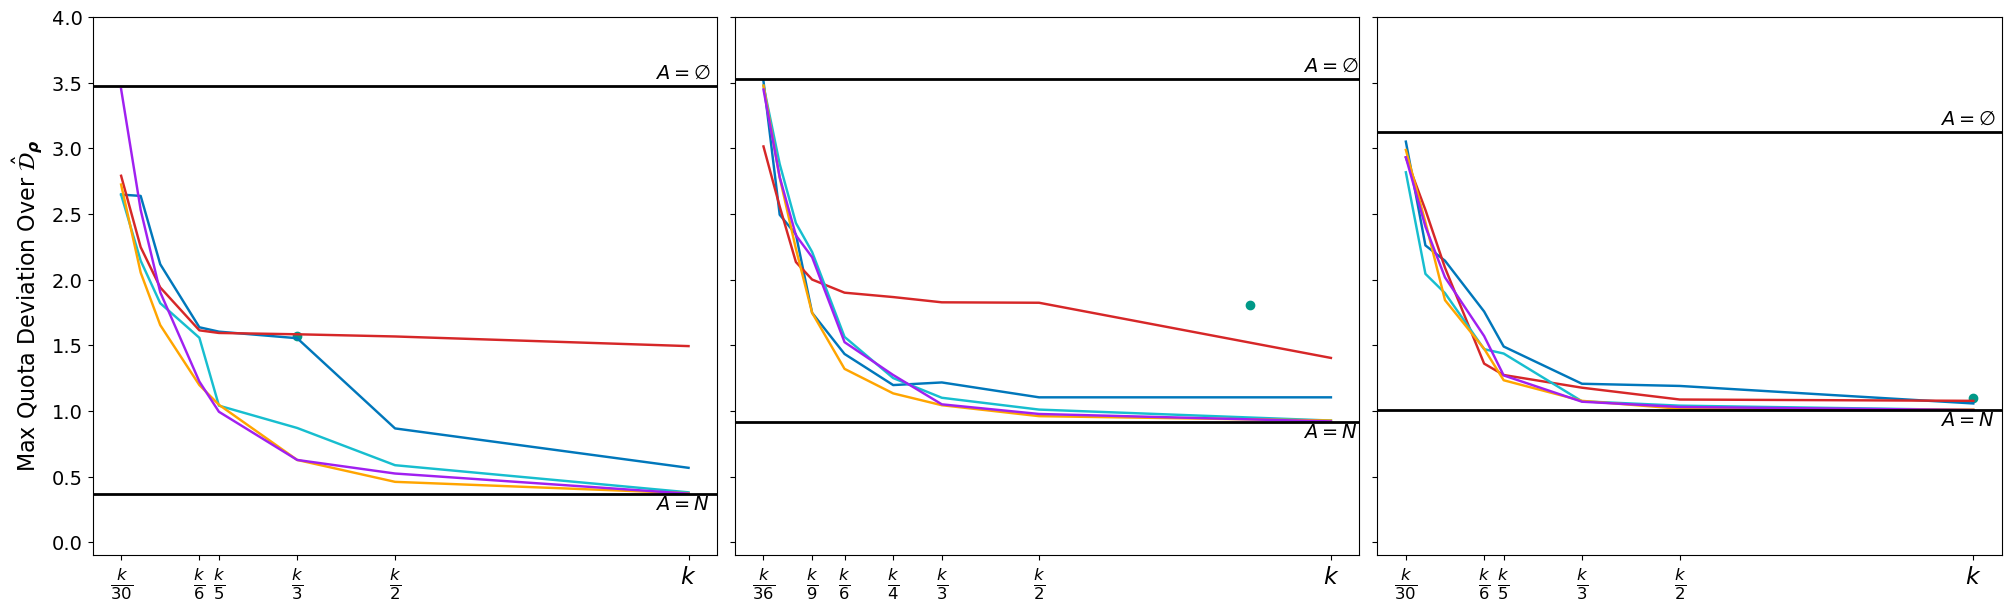

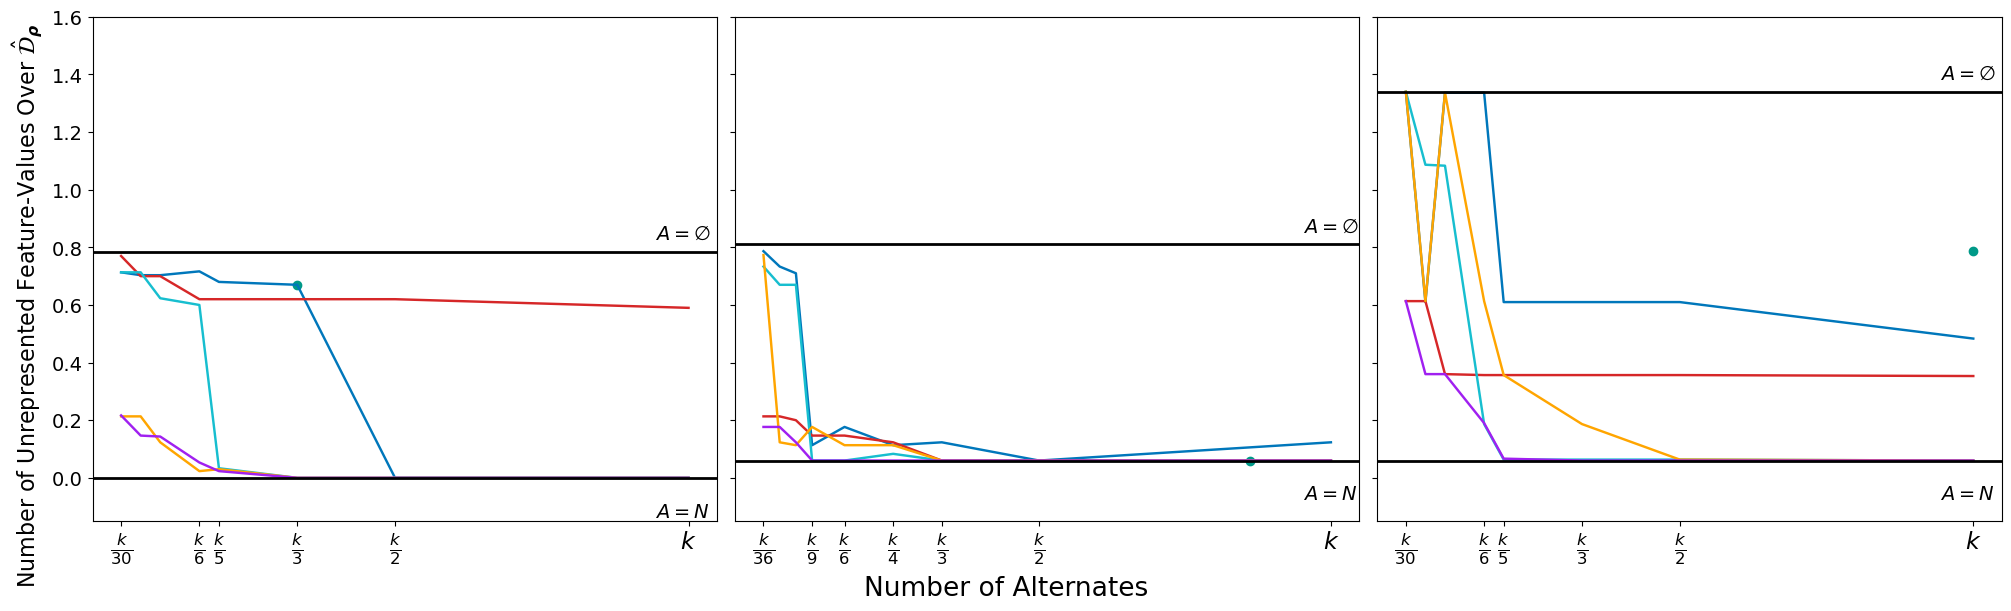

In [ ]:
# plotting different loss metrics
possible_loss_metrics = ['l1_dev_below', 'max_quota_dev_norm', 'max_quota_dev', 'num_unrepped']            
dataset = "HD"
pool_drop_string = ''
NUM_BINARY_SAMPLES = 300
NUM_L1_SAMPLES = 300
loss_labels = ['Practitioner', 'Greedy', 'L1 Eq Probs', 'Binary Opt', 'L1 Opt']
y_label_mapping = {'l1_dev_below': r"Normalized Deviation Below Quotas Over $\hat{\mathcal{D}}_{\boldsymbol{\rho}}$",
                   'max_quota_dev_norm': r"Max Normalized Quota Deviation Over $\hat{\mathcal{D}}_{\boldsymbol{\rho}}$",
                    'max_quota_dev': r"Max Quota Deviation Over $\hat{\mathcal{D}}_{\boldsymbol{\rho}}$",
                    'num_unrepped': r"Number of Unrepresented Feature-Values Over $\hat{\mathcal{D}}_{\boldsymbol{\rho}}$"}
y_lims_mapping = {'l1_dev_below': (-0.1, 3.15), 'max_quota_dev_norm': (-0.1, 1.0), 'max_quota_dev': (-0.1, 4.0), 'num_unrepped': (-0.15, 1.6)}
for loss_metric in possible_loss_metrics:
    file_path = f"../plots/simulation3/{dataset}/pkls/simulation3_output_loss_{loss_metric}{pool_drop_string}_{NUM_BINARY_SAMPLES}_{NUM_L1_SAMPLES}.pkl"
    with open(file_path, "rb") as f:
        output_data = pickle.load(f)

    all_alt_indices = output_data["all_alt_indices"]
    ubs = output_data["ubs"]
    lbs = output_data["lbs"]
    losses = output_data["losses"]
    ks = output_data["ks"]
    true_prac_loss_tuples = output_data["true_prac_loss_tuples"]
    instance_names = ["Eugene_2020", "Petaluma_2022", "Deschutes_2024"]

    plotting_args = {}
    plotting_args['ylabel'] = y_label_mapping[loss_metric]
    plotting_args['include_titles'] = True if loss_metric == possible_loss_metrics[0] else False
    plotting_args['include_legend'] = plotting_args['include_titles']
    plotting_args['include_xlabels'] = True if loss_metric == possible_loss_metrics[-1] else False
    plotting_args['with_stddev'] = False
    plotting_args['ylim'] = y_lims_mapping[loss_metric]
    plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation3/{dataset}/{dataset}_losses_{loss_metric}{pool_drop_string}_line_plot_no_stddev.pdf", true_prac_loss_tuples, plot_args = plotting_args)
    # plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation3/{dataset}/{dataset}_losses_{loss_metric}{pool_drop_string}_line_plot_with_stddev.pdf", true_prac_loss_tuples, with_stddev=True, ylabel=y_axis_label)

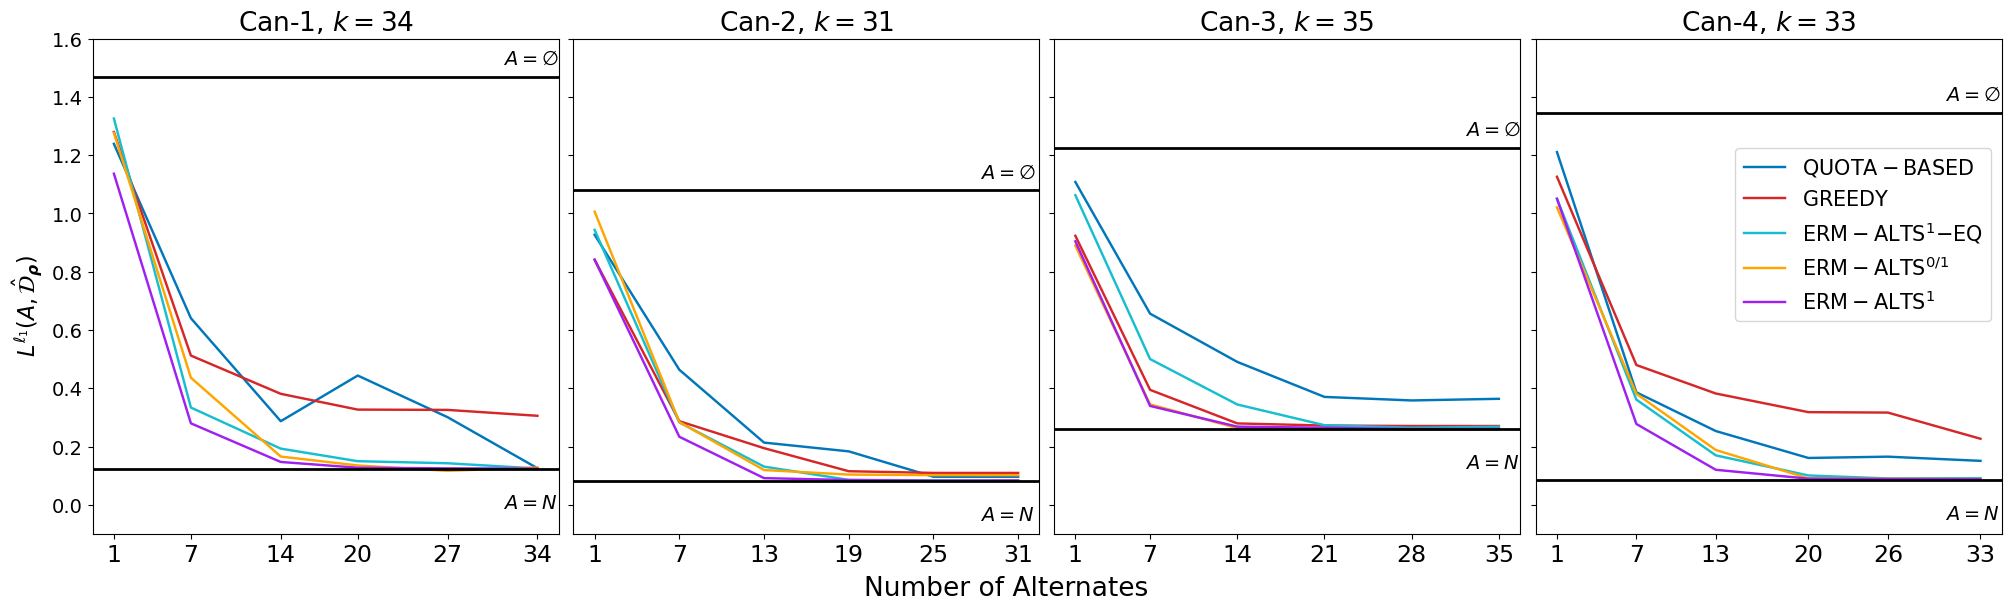

In [82]:
# plotting simulated dropout sets for MASS
loss_metric = "l1"
pool_drop_string = ""
NUM_BINARY_SAMPLES = 300
NUM_L1_SAMPLES = 300
loss_labels = ['Practitioner', 'Greedy', 'L1 Eq Probs', 'Binary Opt', 'L1 Opt']
dataset = "MASS_ALDFN"

file_path = f"../plots/simulation3/{dataset}/pkls/simulation3_output_loss_{loss_metric}{pool_drop_string}_{NUM_BINARY_SAMPLES}_{NUM_L1_SAMPLES}.pkl"
with open(file_path, "rb") as f:
    output_data = pickle.load(f)

all_alt_indices = output_data["all_alt_indices"]
ubs = output_data["ubs"]
lbs = output_data["lbs"]
losses = output_data["losses"]
ks = output_data["ks"]
true_prac_loss_tuples = output_data["true_prac_loss_tuples"]
instance_names = ["ABY", "ABZ", "ACA", "ACB"]
y_axis_label = r"$L^{\ell_1}(A, \hat{\mathcal{D}}_{\boldsymbol{\rho}})$"

mass_plot_args = {'with_stddev': False, 'ylabel': y_axis_label, 'ylim' : (-0.1, 1.6), 'include_titles' : True, 'include_legend' : True, 'include_xlabels': True}

#alt_indices, upper_bound, lower_bound, losses, loss_labels, instance_name, k, filename, true_prac_loss =None, loss_type = 'l1', with_stddev = True
plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation3/{dataset}/{dataset}_losses_{loss_metric}_line_plot_no_stddev.pdf", true_prac_loss_tuples, plot_args=mass_plot_args)
# plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation3/{dataset}/{dataset}_losses_{loss_metric}_line_plot_with_stddev.pdf", true_prac_loss_tuples, with_stddev=True, ylabel=y_axis_label)

# plotter.plot_losses_with_shaded_bands(all_alt_indices["Petaluma_2022"], ubs["Petaluma_2022"], lbs["Petaluma_2022"], losses["Petaluma_2022"], loss_labels, "Petaluma_2022", int(ks["Petaluma_2022"]), f"../plots/simulation3/{dataset}/Petaluma_2022_{dataset}_losses_{loss_metric}_shaded_bands.pdf", true_prac_loss=true_prac_loss_tuples["Petaluma_2022"])

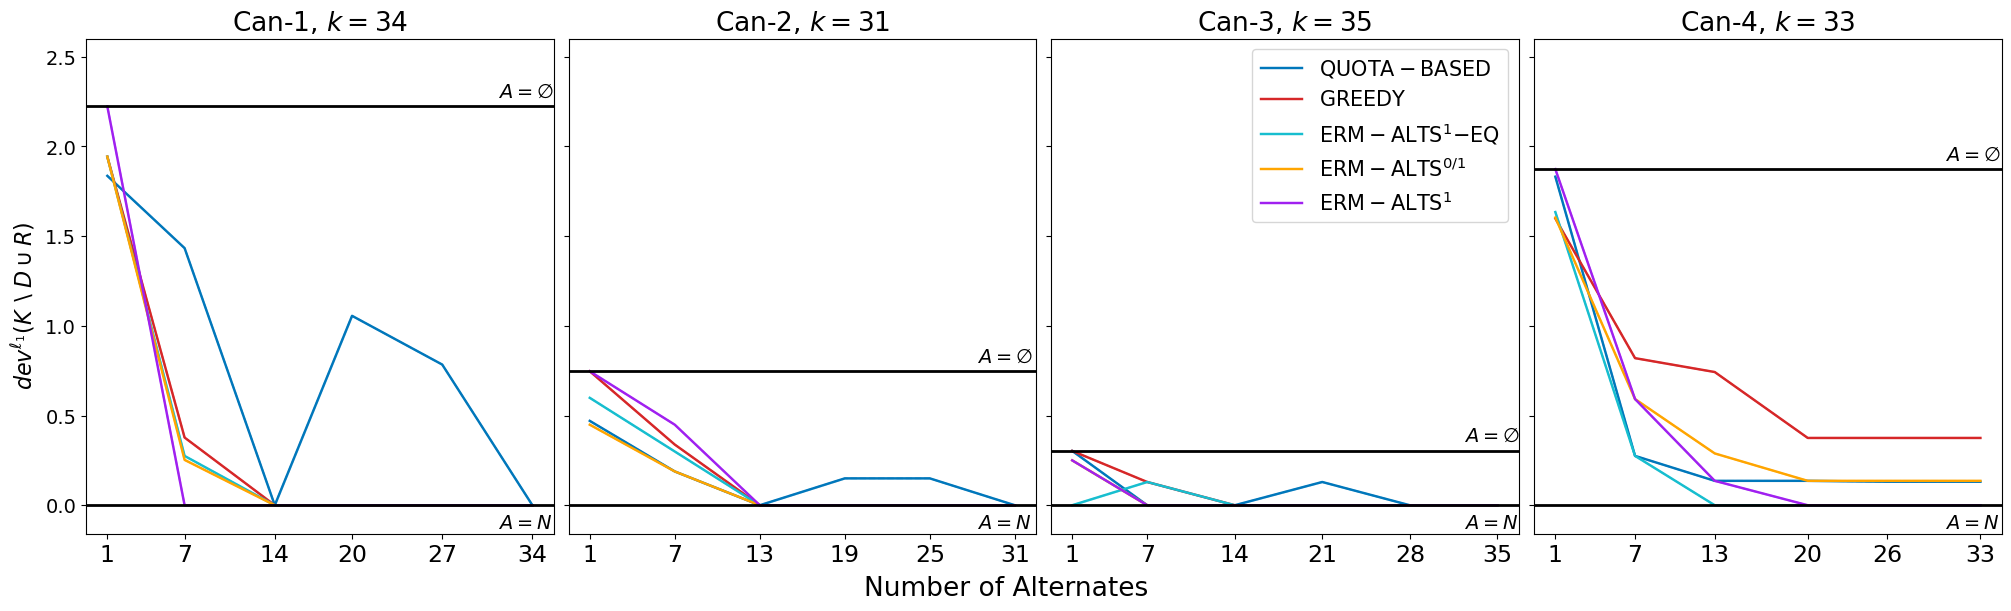

In [ ]:
# plotting real dropout sets for MASS
loss_metric = "l1"
pool_drop_string = ""
NUM_BINARY_SAMPLES = 300
NUM_L1_SAMPLES = 300
loss_labels = ['Practitioner', 'Greedy', 'L1 Eq Probs', 'Binary Opt', 'L1 Opt']
dataset = "MASS_ALDFN"

file_path = f"../plots/simulation1/{dataset}/pkls/simulation1_output_loss_{loss_metric}{pool_drop_string}_{NUM_BINARY_SAMPLES}_{NUM_L1_SAMPLES}.pkl"
with open(file_path, "rb") as f:
    output_data = pickle.load(f)

all_alt_indices = output_data["all_alt_indices"]
ubs = output_data["ubs"]
lbs = output_data["lbs"]
losses = output_data["losses"]
ks = output_data["ks"]
true_prac_loss_tuples = output_data["true_prac_loss_tuples"]
instance_names = ["ABY", "ABZ", "ACA", "ACB"]
y_axis_label = r'$dev^{\ell_1}(K \setminus D \cup R)$'

mass_plot_args = {'with_stddev': True, 'ylabel': y_axis_label, 'ylim' : (-0.16, 2.6), 'include_titles' : True, 'include_legend' : True, 'include_xlabels': True}
#alt_indices, upper_bound, lower_bound, losses, loss_labels, instance_name, k, filename, true_prac_loss =None, loss_type = 'l1', with_stddev = True
plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation1/{dataset}/{dataset}_losses_{loss_metric}_line_plot_with_stddev.pdf", true_prac_loss_tuples, plot_args=mass_plot_args)
# plot_losses_for_dataset(instance_names, all_alt_indices, ubs, lbs, losses, loss_labels, ks, f"../plots/simulation1/{dataset}/{dataset}_losses_{loss_metric}_line_plot_with_stddev.pdf", true_prac_loss_tuples, with_stddev=True)


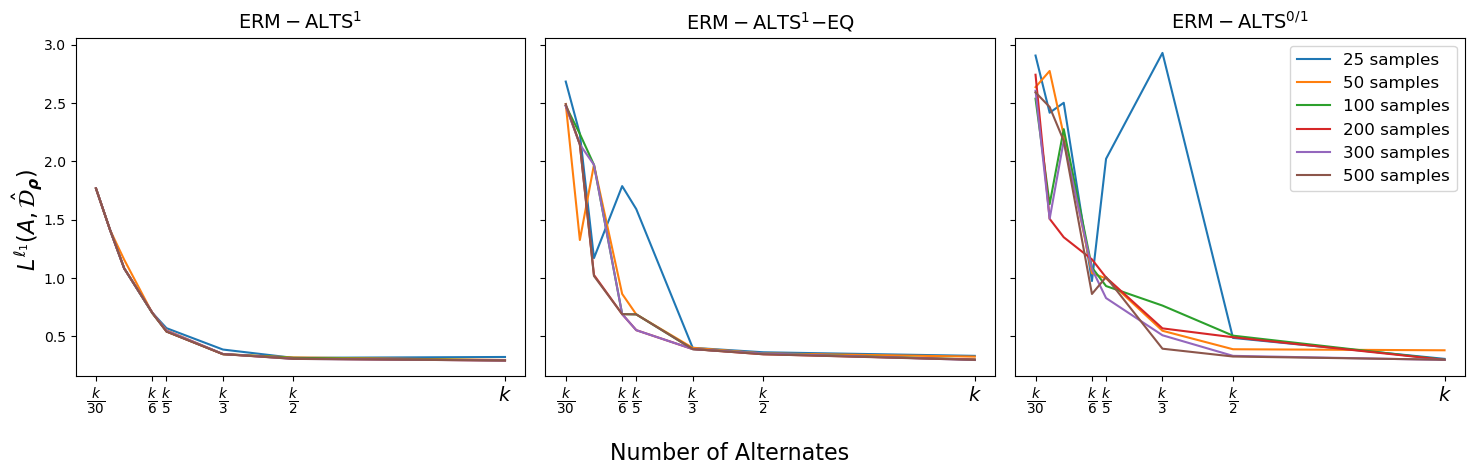

In [ ]:
# convergence plots

num_train_samples = [25, 50, 100, 200, 300, 500]
loss_types = ["l1", "l1_eq", "binary"]
dataset = "HD"
instance_name = "Deschutes_2024"
fig, axs = plt.subplots(1, len(loss_types), figsize=(15, 5), sharey=True)

ALG_OPT_NAMES = {'l1': r'$\mathsf{ERM-ALTS}^1$', 'binary': r'$\mathsf{ERM-ALTS}^{0/1}$', 'l1_eq': r'$\mathsf{ERM-ALTS}^1\mathsf{-EQ}$'}

for j, loss_type in enumerate(loss_types):
    ax = axs[j]
    file_path = f"../plots/l1_num_train_samples_convergence/{dataset}/pkls/{instance_name}_opt_convergence_{max(num_train_samples)}_loss_{loss_type}.pkl"
    with open(file_path, "rb") as f:
        output_data = pickle.load(f)
    alt_indices = output_data["alt_indices"]
    losses = output_data["losses"]
    labeled_alt_indices = [ind for ind in alt_indices if ind < 2 or ind > 3]
    xticks = [f"$\\frac{{k}}{{{30//int(x)}}}$" if int(x) != 30 else r"$k$" for x in labeled_alt_indices]
    ax.set_xticks(labeled_alt_indices)
    ax.set_xticklabels(xticks, fontsize=14)
    for train_sample in num_train_samples:   
        means, stds = losses[train_sample]
        ax.plot(alt_indices, means, label=f"{train_sample} samples")
    
    
    
    ax.set_title(f"{ALG_OPT_NAMES[loss_type]}", fontsize=14)
    if j == 2:
        ax.legend(fontsize=12)
        
fig.supylabel(r"$L^{\ell_1}(A, \hat{\mathcal{D}}_{\boldsymbol{\rho}})$", fontsize=16)
fig.supxlabel("Number of Alternates", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"../plots/l1_num_train_samples_convergence/{dataset}/{instance_name}_l1_l1_eq_binary_convergence_plot.pdf", bbox_inches='tight')
plt.show()

